# Week 04 Assignment weather data

Welcome to week four of this course programming 1. You will to organise your data into the required format and apply smoothing. In this assignment we will work with weatherdata from the KNMI. A subset of weatherdata is for you available in the file: `KNMI_20181231.csv`. The data consist of several stations with daily weather data of several years. Your task is to make a plot similar to the plot below.


<img src="images/weather.png" alt="drawing" width="400"/>


Furthermore the plot needs the following enhancements

1. proper titles and ticks
2. a slider widget selecting a particular year or all years
3. lines need to be smoothed
3. legends needs to be added

Use your creativity. Consider colors, alpha settings, sizes etc. 

Learning outcomes

- load, inspect and clean a dataset 
- reformat dataframes
- apply smoothing technologies
- visualize timeseries data

The assignment consists of 6 parts:

- [part 1: load the data](#0)
- [part 2: clean the data](#1)
- [part 3: reformat data](#2)
- [part 4: smooth the data](#3)
- [part 5: visualize the data](#4)
- [part 6: Challenge](#5)

Part 1 and 5 are mandatory, part 6 is optional (bonus)
To pass the assingnment you need to a score of 60%. 


---

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
def get_config():
    """
    Read in config file and return it as a dictionary.
    """
    with open("config.yaml", 'r') as stream:
        config = yaml.safe_load(stream)
    return config

config = get_config()
data_dir = config['datadir']

<a name='0'></a>
## Part 1: Load the data

Either load the dataset `KNMI_20181231.csv` or `KNMI_20181231.txt.tsv`. The dataheaders contain spaces and are not very self explainable. Change this into more readable ones. Select data from station 270. Select only the mean, minimum and maximum temperature. The data should look something like this:


In [3]:
# Read in the data
knmi_data = pd.read_csv(Path(data_dir + "KNMI_20181231.txt.tsv"), comment="#", header = None, low_memory = False)

# Remove leading white spaces from the columns names
# knmi_data.columns = knmi_data.columns.str.lstrip()

# Rename the columns
knmi_data.rename(columns={0: "station",
                         1:"date",
                         2: "Tmean",
                         3: "Tmin",
                         4: "Tmax"}, inplace = True)

# Only keep interesting columns
cols_to_keep = ["station", "date", "Tmean", "Tmin", "Tmax"]
knmi_data = knmi_data[cols_to_keep]

# Get data from station 270
data_270 = knmi_data[knmi_data["station"] == 270]
data_270.head()
knmi_data

,station,date,Tmean,Tmin,Tmax
0,209,20010130,,,
1,209,20010131,,,
2,209,20010201,,,
3,209,20010202,,,
4,209,20010203,,,
...,...,...,...,...,...
331311,391,20181227,12,-18,47
331312,391,20181228,7,-29,30
331313,391,20181229,59,25,92
331314,391,20181230,78,52,87


---

<a name='1'></a>
## Part 2: Clean the data

The data ia not clean. There are empty cells in the dataframe which needs to be replaced with NaN's and the temperature is in centidegrees which needs to be transformed into degrees. The date field needs a datetime format. For visualization convience we would like to remove the leap year. Conduct the cleaning.

In [4]:
try:
    # Repalce the empty cells with NaN values
    knmi_data = knmi_data.replace(r'^\s*$', np.NaN, regex=True)

    # Change data formats
    
    # Station
    knmi_data.station = knmi_data.station.astype("int64")
    
    # Date
    knmi_data["date"]  = pd.to_datetime(knmi_data['date'].astype(str), format='%Y%m%d')
    
    # Tmean, Tmin, Tmax
    knmi_data[["Tmean", "Tmin", "Tmax"]] = knmi_data[["Tmean", "Tmin", "Tmax"]].astype("float64")
    
    def is_leapCheck(s):
        """
        Check if a year in a series of years is a leap year or not.
        
        :parameters
        -----------
        s - array like
            Years
            
        :returns
        --------
        leap - array like
            List of booleans, True if a year is a leap year and False if a year is not a leap year.
        """
        # Remove the first part because you only need to remove the leap year.
        # leap = (s.dt.year % 4 == 0) & ((s.dt.year % 100 != 0) | (s.dt.year % 400 == 0)) & (s.dt.month == 2) & (s.dt.day == 29)
        leap = (s.dt.month == 2) & (s.dt.day == 29)
        return leap

    # Exclude leap years
    knmi_data = knmi_data[~is_leapCheck(knmi_data["date"])]
    
    # Change the unit of Tmean Tmin and Tmax from centidegrees to degrees
    knmi_data[['Tmean', 'Tmin', 'Tmax']] = knmi_data[['Tmean', 'Tmin', 'Tmax']].applymap(lambda x:x/10)
    
    # Set date as the index
    # knmi_data.set_index("date", inplace = True, drop = False)
    
except Exception as e:
    print(f"Dataframe has already been cleaned. error: {e}")


knmi_data

,station,date,Tmean,Tmin,Tmax
0,209,2001-01-30,NaN,NaN,NaN
1,209,2001-01-31,NaN,NaN,NaN
2,209,2001-02-01,NaN,NaN,NaN
3,209,2001-02-02,NaN,NaN,NaN
4,209,2001-02-03,NaN,NaN,NaN
...,...,...,...,...,...
331311,391,2018-12-27,1.2,-1.8,4.7
331312,391,2018-12-28,0.7,-2.9,3.0
331313,391,2018-12-29,5.9,2.5,9.2
331314,391,2018-12-30,7.8,5.2,8.7


In [5]:
# Grab data from only station 270
knmi_270 = knmi_data[knmi_data["station"] == 270]
knmi_270

,station,date,Tmean,Tmin,Tmax
97641,270,2000-01-01,4.2,-0.4,7.9
97642,270,2000-01-02,5.5,3.3,7.4
97643,270,2000-01-03,7.4,4.9,8.9
97644,270,2000-01-04,4.6,2.2,7.5
97645,270,2000-01-05,4.1,1.4,5.6
...,...,...,...,...,...
104576,270,2018-12-27,5.7,5.3,6.2
104577,270,2018-12-28,7.1,5.8,8.1
104578,270,2018-12-29,8.5,6.9,10.2
104579,270,2018-12-30,8.0,6.8,9.0


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<ul><li>pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')</li>
    <li>regex for empty cells = `^\s*$` </li>
    <li>remove month == 2 & day == 29</li> 
</ul>
</details>

In [6]:
#Test your outcome
knmi_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331078 entries, 0 to 331315
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   station  331078 non-null  int64         
 1   date     331078 non-null  datetime64[ns]
 2   Tmean    237394 non-null  float64       
 3   Tmin     237395 non-null  float64       
 4   Tmax     237395 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 15.2 MB


### Expected outcome

---

<a name='2'></a>
## Part 3: Reform your data

First we will split the data in data from 2018 and data before 2018. Best is to split this in two dataframes. 
Next we need for the non 2018 data the minimum values for each day and the maximum values for each day. So we look for the minimum value out of all january-01 minimum values (regardless the year). Create a dataframe with 365 days containing the ultimate minimum and the ultimate maximum per day. 


In [7]:
# Get the dataframe for all rows that were before 2018
before_2018 = knmi_270[knmi_270['date'].dt.year < 2018]

# Get the dataframe for all rows that have the year 2018 or higher
after_2018 = knmi_270[knmi_270['date'].dt.year >= 2018]

b_2018 = before_2018.copy() # create copy from both dfs
a_2018 = after_2018.copy()

# Create a seperate month and day column
b_2018["Month"] = b_2018['date'].dt.month
b_2018["Day"] = b_2018['date'].dt.day

# Grab the minumum value vor each day across all years
min_vals = b_2018.groupby(['Month', 'Day']).Tmin.min()

# Another possible solution:
min_max_vals = b_2018.groupby(['Month', 'Day']).agg({'Tmin': ['min'], "Tmax":['max']})# https://www.statology.org/pandas-groupby-aggregate-multiple-columns/
min_max_vals.columns = ["Tmin", "Tmax"] # reset the column names to turn it back into a normal DataFrame

min_max_vals

Tmin  Tmax
Month Day            
1     1    -5.8  11.1
      2    -7.5  10.2
      3   -12.6  10.7
      4    -6.7   9.8
      5    -6.2   9.4
...         ...   ...
12    27   -6.0  11.7
      28   -7.4  10.9
      29   -7.3  11.4
      30  -10.2  11.1
      31  -10.6  11.8

[365 rows x 2 columns]

In [8]:
def month_day(df_multipleyears):
    #your code to reform data here
    
    df_oneyear = df_multipleyears.copy()
    
    # Create a seperate month and day column
    df_oneyear["Month"] = df_oneyear['date'].dt.month
    df_oneyear["Day"] = df_oneyear['date'].dt.day
    
    # Grab the minumum value vor each day across all years
    df_groupedbymonthday = df_oneyear.groupby(['Month', 'Day']).agg({'Tmin': ['min'], "Tmax":['max']})

    df_groupedbymonthday.columns = ["Tmin", "Tmax"]# reset the column names to turn it back into a normal DataFrame
    return df_groupedbymonthday
    
df_monthday = month_day(before_2018)
df_monthday

Tmin  Tmax
Month Day            
1     1    -5.8  11.1
      2    -7.5  10.2
      3   -12.6  10.7
      4    -6.7   9.8
      5    -6.2   9.4
...         ...   ...
12    27   -6.0  11.7
      28   -7.4  10.9
      29   -7.3  11.4
      30  -10.2  11.1
      31  -10.6  11.8

[365 rows x 2 columns]

In [9]:
#Test your code
def test_reformed(df): 
    #
    df = df[(df.date.dt.year > 2007) & (df.date.dt.year < 2018)]
    df_monthday = month_day(df)
    
    return df_monthday

df_monthday = test_reformed(knmi_270)
df_monthday

Tmin  Tmax
Month Day            
1     1    -5.8  11.1
      2    -7.5  10.2
      3   -12.6  10.7
      4    -4.1   9.2
      5    -6.0   8.4
...         ...   ...
12    27   -4.8  11.7
      28   -4.2  10.9
      29   -6.7  11.4
      30  -10.2   9.5
      31  -10.6  11.8

[365 rows x 2 columns]

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<ul><li>use the dt.month and dt.day to groupby</li>
</ul>
</details>

### Expected outcome
Note, the layout or names my differ, but the length should be 365 and the minimum values should be the same

---

<a name='3'></a>
## Part 4: Smooth the data

Make a function that takes an array or a dataframe column and returns an array of smoothed data. Explain in words why you choose a certain smoothing algoritm


In [10]:
# Is there a trend? Is it seasonal data?
    # * Stationarizing the data
    # * Use Augmented Dickey-Fuller Test to check if data is stationary

# What method to use?
    # * SARIMA
    # * Holt-winters Exponentional Smoothing
    # * Normal exponentional smoothing
    
# Useful link for Holt, SARIMA, and Stationarizing the data: 
    # * https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051
    
    
# Info:
    # * we have: multiplicative seasonal data with a trend (my opinion)
    # * How to de-trend time series data: https://www.statology.org/detrend-data/
        # * using linear fit: https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051
    
    
# Determine what forecasting method is best for your data:
    # * https://docs.oracle.com/cd/E57185_01/CBPUG/ch03s04s01.html
    # Exponential smoothing methods—While the moving averages give equal weights to included values, single exponential smoothing assigns exponentially decreasing weights as the observation get older, a more reasonable approach. When a time series has a trend, double exponential smoothing is useful and is computed by smoothing the series twice.

### Determine if the data has a trend and if it displays seasonality.

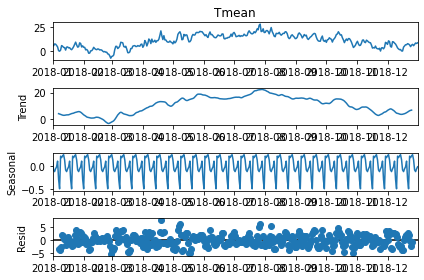

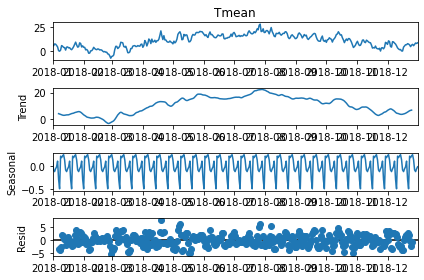

In [11]:
df = after_2018.copy()
df.set_index('date', inplace = True)
ts = df["Tmean"]


decompose_result = seasonal_decompose(ts, model = "additive", period=12)
decompose_result.plot()

From this plot we can see that the data does indeed have a trend and that it also displays a seasonal component.


### Best smoothing method for the data
There are multiple methods that can be used to smooth time-series data. However, not all time-series data are alike and thus require different methods.Time series can be thought as a mix between three parts: trend, seasonal component and residuals. From the seasonal decompose plot we can see that our data has a trend and that it displays a seasonal component. The trend and seasonal components should be included during the forecasting. A method that includes both trend and seasonal components is called Holt's-winter Exponentional Smoothing (WES)[1]. There are two types of seasonal methods, nameley additive and multiplicative. Additive seasonality means that there is a steady amplitude pattern. For multiplicative seasonality the amplitude pattern increases or decreases over time[2]. Looking at our data I would say that we have additive seasonality.

[1] https://medium.com/analytics-vidhya/a-thorough-introduction-to-holt-winters-forecasting-c21810b8c0e6  
[2] https://docs.oracle.com/cd/E57185_01/CBPUG/ch03s04s01.html

In [12]:
# It is seasonal data, looks like that there is a trend in the data.

# Exponential smoothing: Alpha is weight for most recent observation

# Grab the mean temperature of the year 2018
df = after_2018.copy()
df.set_index('date', inplace = True)
ts = df["Tmean"]

def winters_exponential_smooth(ts, *, period = 4, damped = True, alpha = None):
    """
    Apply Winters-Holt Exponentional Smoothing to time series data. Add seasonal and trend component.
    
    :parameters
    -----------
    ts - array like
        Time series data
    period - int
        The number of periods in a complete seasonal cycle, e.g., 4 for quarterly data or 7 for daily data with a weekly cycle.
    damped - Boolean
        Should the trend component be damped.
    alpha - float
        The alpha value of the simple exponential smoothing, if the value is set then this value will be used as the value.
        
    :returns
    --------
    index - array like
        Original date index
    fitted_values - array like
        Fitted values
    """
    fit = ExponentialSmoothing(ts, seasonal_periods=period, trend='add', seasonal='add', damped_trend=damped).fit(smoothing_level=alpha)
    return fit.season.index, fit.fittedvalues
    
index_2018, fitted_values_2018 = winters_exponential_smooth(ts, alpha = 0.2)

C:\Users\stijn\anaconda3\envs\DSLS_prog1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


---

<a name='4'></a>
## Part 5: Visualize the data

Plot the mean temperature of the year 2018. Create a shaded band with the ultimate minimum values and the ultimate maximum values from the multi-year dataset. Add labels, titles and legends. Use proper ranges. Be creative to make the plot attractive. 



<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<ul><li>use from bokeh.models import Band</li>
    <li>use ColumnDataSource to parse data arrays</li>
    <li>look for xaxis tick formatters</li>
</ul>
</details>

In [13]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot, column
from bokeh.io import output_notebook
from bokeh.plotting import ColumnDataSource
from bokeh.models import DatetimeTickFormatter, Band, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [14]:
# Basic figure structure
p = figure(title = "Temperature station 270.",plot_width = 750, 
           plot_height = 500,
           y_range = (-20, 40),
           tools="pan, hover, zoom_in, zoom_out, yzoom_in, yzoom_out", x_axis_type='datetime')

# Create a ColumnDataSource object from the smoothed data and the overal min and max values
source = ColumnDataSource({"x":index_2018,
                    "mean": fitted_values_2018,
                    "min": df_monthday.Tmin,
                    "max": df_monthday.Tmax})

# Create a band between the min and max values
band = Band(base='x', lower='min', upper='max', source=source, level='underlay',
            fill_alpha=1.0, line_width=1, line_color='black', fill_color = "lightgray")
p.add_layout(band)

line_fit = p.line("x", "mean", legend_label = "Mean temp 2018 (Holt-Winter Exponential Smoothed)", source=source)
p.xaxis.axis_label = 'Date (Month/Year)'
p.yaxis.axis_label = u'Temperature (\u00B0C)'

p.legend.location = "top_left"
p.legend.click_policy="hide"

show(p)

---

<a name='5'></a>
## Part 6: Challenge

Make a widget in which you can select the year range for the multiyear set. Add this to your layout to make the plot interactive. Add another widget to select or deselect the smoother. Inspiration: https://demo.bokeh.org/weather

In [15]:
# Will make the bonus assignment when I have some spare time.